In [2]:
import sys
import os
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# --- 1. ROBUST PATH DISCOVERY ---
current_path = os.path.abspath(os.getcwd())
while not os.path.exists(os.path.join(current_path, 'src')):
    parent = os.path.abspath(os.path.join(current_path, os.pardir))
    if parent == current_path: 
        break
    current_path = parent

if current_path not in sys.path:
    sys.path.append(current_path)

# --- 2. IMPORTS FROM SRC ---
try:
    from src.connectors.yahoo_connector import YahooConnector
    from src.model.bayesian_alpha import BayesianAlphaModel
    from src.optimizer.stochastic_engine import StochasticOptimizer
    from src.utils.visualizer import ResearchVisualizer
    print(f"✅ Project Root Detected: {current_path}")
    print("✅ Libraries loaded successfully.")
except ImportError as e:
    print(f"❌ Import Failed: {e}")

# --- 3. CONFIGURATION ---
logging.getLogger("pymc").setLevel(logging.WARNING)
logging.getLogger("pulp").setLevel(logging.WARNING)
warnings.simplefilter(action='ignore', category=FutureWarning)

viz = ResearchVisualizer()

✅ Project Root Detected: c:\Users\rouba\Documents\python_projects\OptiAlpha
✅ Libraries loaded successfully.


In [3]:
# 1. Define Universe
universe = ["XLE", "XLF", "QQQ", "GLD", "BND"]
benchmark = "SPY"

# 2. Fetch Historical Data
connector = YahooConnector()
data_map = {}

print("--- Fetching Real Market Data (2 Years) ---")
for ticker in universe + [benchmark]:
    print(f"📥 Loading {ticker}...")
    df = connector.get_historical_returns(ticker, period="2y")
    if not df.empty:
        data_map[ticker] = df

# 3. Align Data
realized_returns = pd.DataFrame(data_map).dropna()

print(f"\n✅ Data Successfully Aligned.")
print(f"📅 Date Range: {realized_returns.index[0].date()} to {realized_returns.index[-1].date()}")
display(realized_returns.tail())

--- Fetching Real Market Data (2 Years) ---
📥 Loading XLE...
📥 Loading XLF...
📥 Loading QQQ...
📥 Loading GLD...
📥 Loading BND...
📥 Loading SPY...

✅ Data Successfully Aligned.
📅 Date Range: 2024-02-15 to 2026-02-13


,XLE,XLF,QQQ,GLD,BND,SPY
Date,,,,,,
2026-02-09 00:00:00-05:00,0.007324,-0.005898,0.007660,0.025403,0.000269,0.004822
2026-02-10 00:00:00-05:00,-0.001119,-0.007230,-0.004639,-0.009914,0.002963,-0.002637
2026-02-11 00:00:00-05:00,0.026129,-0.015126,0.002682,0.011311,-0.002014,-0.000231
2026-02-12 00:00:00-05:00,-0.018188,-0.019909,-0.020339,-0.034728,0.004575,-0.015449
2026-02-13 00:00:00-05:00,0.006854,-0.000774,0.002131,0.024879,0.002947,0.000705


In [4]:
def run_full_bayesian_backtest(returns_df, universe, lookback=60, rebalance_freq=20):
    dates = returns_df.index
    n_days = len(dates)
    weights_history = []
    
    # Initial Weights (100% Bonds)
    current_weights = {t: 0.0 for t in universe}
    if "BND" in universe:
        current_weights["BND"] = 1.0
    
    # Static Betas (For demo purposes)
    betas = {"XLE": 1.1, "XLF": 1.0, "QQQ": 1.2, "GLD": 0.1, "BND": 0.05}

    print(f"🚀 Starting Simulation: {n_days} days | Rebalance: Every {rebalance_freq} days")
    
    for t in tqdm(range(lookback, n_days), desc="Simulating Trading Days"):
        current_date = dates[t]
        
        # --- Rebalance Logic ---
        if (t - lookback) % rebalance_freq == 0:
            window_start = t - lookback
            window_end = t
            train_data = returns_df.iloc[window_start:window_end]
            
            scenarios = {}
            
            for ticker in universe:
                try:
                    asset_returns = train_data[ticker]
                    
                    # Feature Engineering: Momentum Signal
                    # (Price / Price_20d_ago) - 1
                    price_path = (1 + asset_returns).cumprod()
                    signal = (price_path / price_path.shift(20) - 1).fillna(0)
                    
                    # Train Bayesian Model (Fit on past, Predict for tomorrow)
                    # n_samples=500 for speed in the loop
                    model = BayesianAlphaModel(n_samples=500)
                    
                    # Align indices to ensure no NaNs
                    valid_idx = signal.index.intersection(asset_returns.index)
                    if len(valid_idx) > 20:
                        # Shift: Signal(T) predicts Return(T+1)
                        model.fit(asset_returns.loc[valid_idx].iloc[1:], signal.loc[valid_idx].iloc[:-1])
                        
                        current_signal_val = signal.iloc[-1]
                        scenarios[ticker] = model.predict_scenarios(current_signal_val, n_scenarios=1000)
                    else:
                        raise ValueError("Insufficient data")

                except Exception:
                    # Fallback if MCMC fails or not enough data
                    mu = asset_returns.mean()
                    scenarios[ticker] = np.random.normal(mu, 0.015, 1000)
            
            # --- Optimization ---
            opt = StochasticOptimizer(universe, scenarios, betas)
            new_weights = opt.solve(max_positions=4)
            
            if new_weights:
                current_weights = {tk: new_weights.get(tk, 0.0) for tk in universe}
        
        # Record Daily Weights
        daily_record = current_weights.copy()
        daily_record['Date'] = current_date
        weights_history.append(daily_record)
        
    return pd.DataFrame(weights_history).set_index('Date')

In [5]:
def run_full_bayesian_backtest(returns_df, universe, lookback=60, rebalance_freq=20):
    """
    Executes a rolling backtest using Analytical Bayesian Inference.
    Speed: ~1000x faster than MCMC.
    """
    dates = returns_df.index
    n_days = len(dates)
    weights_history = []
    
    # Initial Weights (100% Bonds)
    current_weights = {t: 0.0 for t in universe}
    if "BND" in universe:
        current_weights["BND"] = 1.0
    
    # Static Betas
    betas = {"XLE": 1.1, "XLF": 1.0, "QQQ": 1.2, "GLD": 0.1, "BND": 0.05}

    print(f"🚀 Starting Simulation: {n_days} days | Rebalance: Every {rebalance_freq} days")
    
    # Use tqdm for a progress bar
    for t in tqdm(range(lookback, n_days), desc="Processing"):
        current_date = dates[t]
        
        # --- Rebalance Logic ---
        if (t - lookback) % rebalance_freq == 0:
            window_start = t - lookback
            window_end = t
            train_data = returns_df.iloc[window_start:window_end]
            
            scenarios = {}
            
            for ticker in universe:
                try:
                    asset_returns = train_data[ticker]
                    
                    # Feature Engineering: Momentum Signal
                    # (Price / Price_20d_ago) - 1
                    price_path = (1 + asset_returns).cumprod()
                    signal = (price_path / price_path.shift(20) - 1).fillna(0)
                    
                    # Validation: Ensure we have variance (flat lines break regression)
                    if signal.std() < 1e-6 or asset_returns.std() < 1e-6:
                         raise ValueError("Flat data")

                    # Initialize & Fit (Now Instantaneous)
                    model = BayesianAlphaModel()
                    
                    valid_idx = signal.index.intersection(asset_returns.index)
                    if len(valid_idx) > 20:
                        # Train on past
                        model.fit(asset_returns.loc[valid_idx].iloc[1:], signal.loc[valid_idx].iloc[:-1])
                        
                        # Predict for tomorrow
                        current_signal_val = signal.iloc[-1]
                        scenarios[ticker] = model.predict_scenarios(current_signal_val, n_scenarios=1000)
                    else:
                        raise ValueError("Insufficient Data")

                except Exception:
                    # Fallback: Mean Reversion assumption
                    mu = asset_returns.mean()
                    sigma = asset_returns.std()
                    scenarios[ticker] = np.random.normal(mu, sigma, 1000)
            
            # --- Optimization ---
            opt = StochasticOptimizer(universe, scenarios, betas)
            new_weights = opt.solve(max_positions=4)
            
            if new_weights:
                current_weights = {tk: new_weights.get(tk, 0.0) for tk in universe}
        
        # Record Daily Weights
        daily_record = current_weights.copy()
        daily_record['Date'] = current_date
        weights_history.append(daily_record)
        
    return pd.DataFrame(weights_history).set_index('Date')

In [7]:
# --- CELL 4: EXECUTE SIMULATION ---

# 1. Run the Backtest
# We use a 60-day lookback for training and rebalance every 20 days
try:
    df_weights = run_full_bayesian_backtest(
        realized_returns, 
        universe, 
        lookback=60, 
        rebalance_freq=20
    )

    print("✅ Backtest Complete.")
    print("Last Allocation:")
    print(df_weights.iloc[-1][df_weights.iloc[-1] != 0])

except Exception as e:
    print(f"❌ Simulation Failed: {e}")
    print("Tip: Ensure you installed scikit-learn (!pip install scikit-learn) and restarted the kernel.")

🚀 Starting Simulation: 501 days | Rebalance: Every 20 days


Processing:   0%|          | 0/441 [00:00<?, ?it/s]

✅ Backtest Complete.
Last Allocation:
XLE    0.5020
QQQ   -0.4733
GLD    0.3435
BND   -0.3722
Name: 2026-02-13 00:00:00-05:00, dtype: float64



--- 🏆 FINAL RESULTS ---
Strategy  | Sharpe: 1.22 | Max Drawdown: -13.48%
Benchmark | Sharpe: 1.06 | Max Drawdown: -20.23%

Plotting Equity Curve...
Figure saved: reports/figures\equity_curve.png


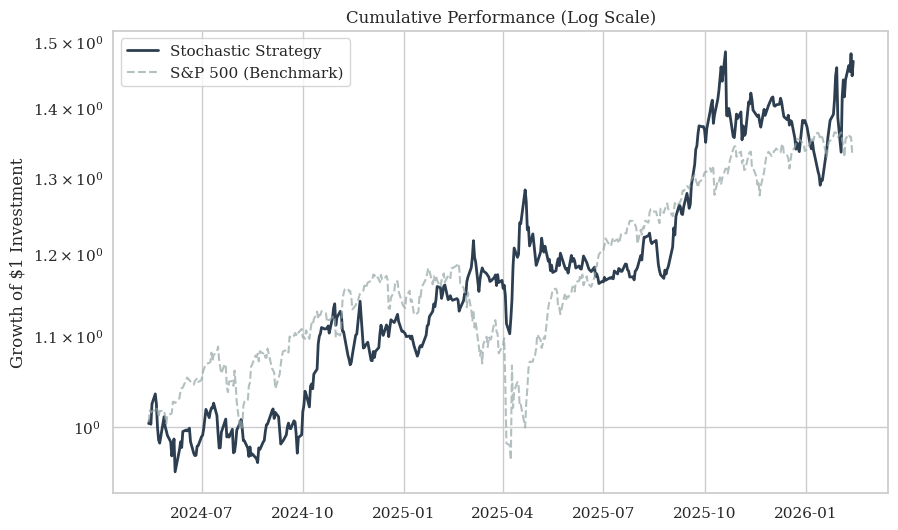


Plotting Dynamic Allocation...
Figure saved: reports/figures\allocation_tunnel.png


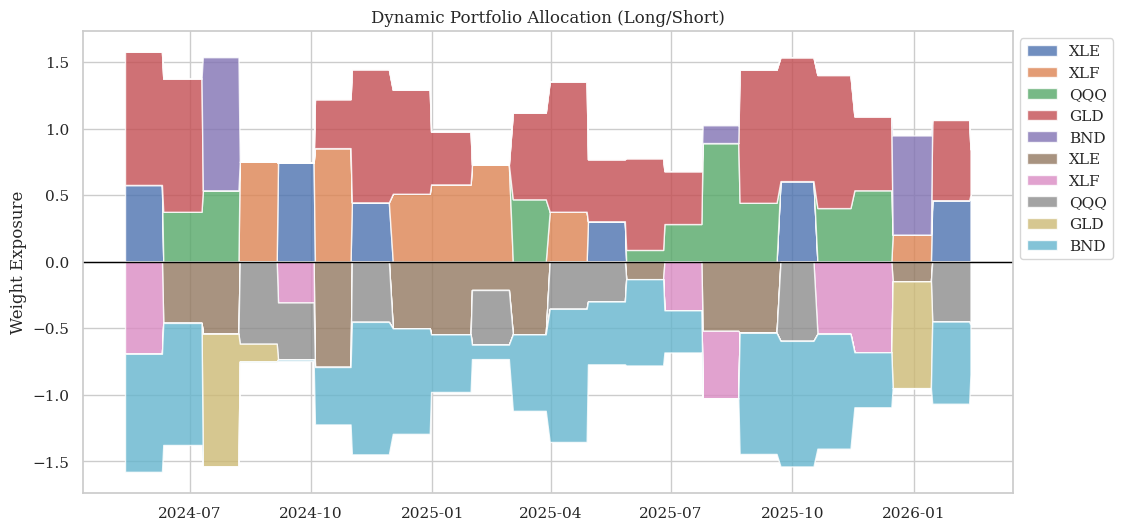


Plotting P&L Attribution...
Figure saved: reports/figures\pnl_attribution.png


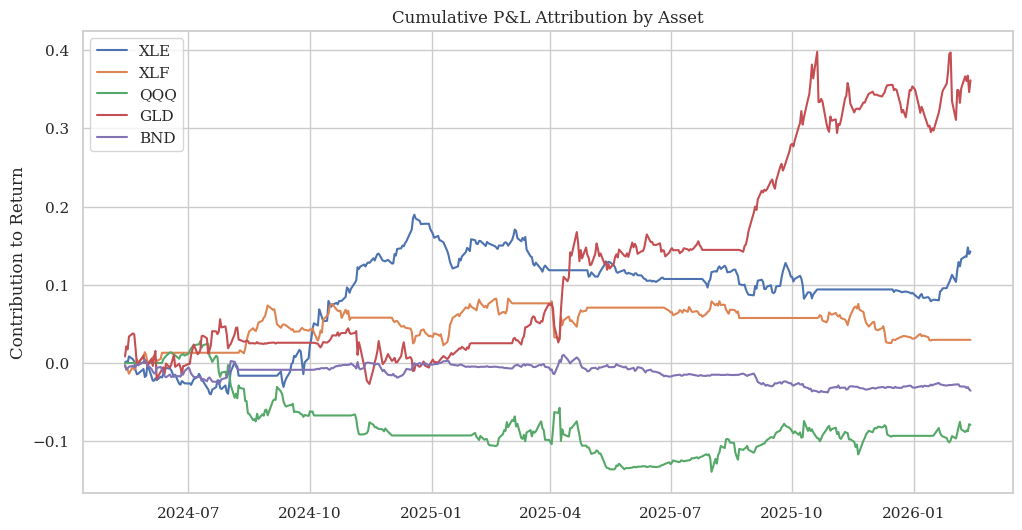

In [8]:
# 1. Calculate Strategy Returns (Shift weights by 1 day)
aligned_weights = df_weights.shift(1).dropna()
common_idx = aligned_weights.index.intersection(realized_returns.index)

strat_ret = (aligned_weights.loc[common_idx] * realized_returns.loc[common_idx, universe]).sum(axis=1)
bench_ret = realized_returns.loc[common_idx, "SPY"]

# 2. Metrics
def calculate_metrics(series):
    sharpe = (series.mean() / series.std()) * np.sqrt(252)
    dd = (series.cumsum() - series.cumsum().cummax()).min()
    return sharpe, dd

s_sharpe, s_dd = calculate_metrics(strat_ret)
b_sharpe, b_dd = calculate_metrics(bench_ret)

print(f"\n--- 🏆 FINAL RESULTS ---")
print(f"Strategy  | Sharpe: {s_sharpe:.2f} | Max Drawdown: {s_dd:.2%}")
print(f"Benchmark | Sharpe: {b_sharpe:.2f} | Max Drawdown: {b_dd:.2%}")

# 3. Visualizations
print("\nPlotting Equity Curve...")
viz.plot_equity_curve(strat_ret, bench_ret)

print("\nPlotting Dynamic Allocation...")
viz.plot_dynamic_allocation(df_weights)

print("\nPlotting P&L Attribution...")
asset_pnl = aligned_weights.loc[common_idx] * realized_returns.loc[common_idx, universe]
viz.plot_attribution(asset_pnl.cumsum())